In [1]:
%load_ext autoreload
%autoreload 2
from module_test.raw_code.optionlib_2.vol.implied_vol import (
    bsm_vol_est_brute_force,
    bsm_vol_est_minimization,
    vector_vol_estimation
)
from module_test.raw_code.optionlib_2.assets.forward import (
    EquityForward, 
    time_distance_helper,
    vectorized_market_forward_calc
)
from datetime import datetime
from dbase.DataAPI.ThetaData import retrieve_chain_bulk
from trade.helpers.helper import change_to_last_busday, retrieve_timeseries
import os
  
from module_test.raw_code.optionlib_2.vol.implied_vol import (
    estimate_crr_implied_volatility,
    vol_est_brute_force_bjs_2002,
    vector_vol_estimation
)
from module_test.raw_code.optionlib_2.assets.forward import (
    EquityForward, 
    time_distance_helper,
    get_vectorized_dividend_rate,
    get_vectorized_dividend_scehdule
)

from module_test.raw_code.optionlib_2.assets.dividend import (
    vector_convert_to_time_frac
)

from module_test.raw_code.optionlib_2.greeks.numerical.bjs2002 import (
    bjs2002_numerical_greeks,
)

from module_test.raw_code.optionlib_2.greeks.numerical.binomial import (
    binomial_tree_greeks,
)
from datetime import datetime
from dbase.DataAPI.ThetaData import retrieve_chain_bulk
from trade.helpers.helper import change_to_last_busday, retrieve_timeseries
import os
import numpy as np
from trade.assets.rates import get_risk_free_rate_helper
from module_test.raw_code.optionlib_2.utils.batch_operation import vector_batch_processor
os.environ['PROXY_URL'] = ''
from dbase.DataAPI.ThetaData import (
    list_contracts,
    retrieve_eod_ohlc,
    retrieve_chain_bulk
)
def get_spot(tick, date):
    return retrieve_timeseries(tick, date, date)['close'][0]
test_start, test_valuation_date = '2025-07-16', '2025-07-16'


Console Logging & File Logging Can be configured using STREAM_LOG_LEVEL and FILE_LOG_LEVEL in environment variables.
Propagate to root logger can be set using PROPAGATE_TO_ROOT_LOGGER in environment variables.
Example:
STREAM_LOG_LEVEL = 'DEBUG'
FILE_LOG_LEVEL = 'INFO'
PROPAGATE_TO_ROOT_LOGGER = 'False'

2025-07-28 10:33:13 trade.helpers.Logging INFO: Logging Root Directory: /Users/chiemelienwanisobi/cloned_repos/QuantTools/logs
Using Proxy URL: http://54.144.4.219:5500/thetadata


In [2]:
import pandas as pd
pd.options.plotting.backend = "plotly"

In [3]:
ticks = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
test_start, test_valuation_date = '2025-07-16', '2025-07-16'
def pick_random_option(tick, date):
    contracts = list_contracts(tick, date)
    # Pick a random contract from the list
    contract = np.random.choice(contracts.index)
    return contracts.iloc[contract]

def get_option_eod_price(date, contract_series):
    """
    Retrieves the end-of-day price for a given option contract on a specific date.
    
    Args:
        date (datetime): The date for which to retrieve the price.
        contract_series (pd.Series): The series containing option contract details.
        
    Returns:
        float: The end-of-day price of the option contract.
    """
    eod_data = retrieve_eod_ohlc(symbol=contract_series['root'],
                                  end_date=date,
                                  start_date=date,
                                  exp=str(contract_series['expiration']),
                                  right=contract_series['right'],
                                  strike=contract_series['strike'],
                                  )
    return eod_data.Midpoint[0]

def get_spot(tick, date):
    return retrieve_timeseries(tick, date, date)['close'][0]

# contract = pick_random_option(ticks[0], test_start)
# eod = get_option_eod_price(test_start, contract)
spot = retrieve_timeseries(ticks[0], test_start, test_start)['close'][0]
rates = get_risk_free_rate_helper()['annualized'][test_start]


[get_engine] Creating engine for DB: securities_master, PID: 97306
YF.download() has changed argument auto_adjust default to True


In [4]:
aapl_chain=retrieve_chain_bulk(
    'AAPL',
    0,
    change_to_last_busday(test_valuation_date),
    change_to_last_busday(test_valuation_date),
    '16:00'

)
S = get_spot('AAPL', (test_valuation_date))

In [5]:
aapl_chain = aapl_chain[aapl_chain['Expiration'] >= test_valuation_date]
valuation_dates = [test_valuation_date] * len(aapl_chain)
end_dates = aapl_chain['Expiration'].tolist()
r = [rates] * len(aapl_chain)
s = [S] * len(aapl_chain)
tickers = ['AAPL'] * len(aapl_chain)
F = vectorized_market_forward_calc(
    ticks=tickers,
    S=s,
    valuation_dates=valuation_dates,
    end_dates=end_dates,
    r=r,
    div_type='discrete'
)
F

array([211.06290119, 211.23415549, 211.06290119, ..., 210.72080899,
       217.71608065, 217.71608065], shape=(2428,))

In [6]:
T = [time_distance_helper(end_dates[i], valuation_dates[i]) for i in range(len(aapl_chain))]
q = get_vectorized_dividend_rate(
    tickers=tickers,
    spots=s,
    valuation_dates=valuation_dates,
)


discrete_q = get_vectorized_dividend_scehdule(
    tickers=['AAPL'] * len(aapl_chain),
    valuation_dates=[test_valuation_date] * len(aapl_chain),
    end_dates=aapl_chain['Expiration'].tolist(),
    start_dates=[test_valuation_date] * len(aapl_chain),
)

discrete_q_convert = vector_convert_to_time_frac(
    discrete_q, 
    valuation_dates=[test_valuation_date] * len(aapl_chain), 
    end_dates=aapl_chain['Expiration'].tolist(), 
)

In [7]:
params = list(zip(
    F, 
    aapl_chain['Strike'], 
    T,
    r, 
    aapl_chain['Midpoint'], 
    aapl_chain['Right'].str.lower()
))


In [8]:
aapl_chain['S'] = S
aapl_chain['moneyness'] = aapl_chain['Strike'] / S
aapl_chain

,Root,Expiration,Strike,Right,Bid_size,CloseBid,Ask_size,CloseAsk,Date,Midpoint,Weighted_midpoint,S,moneyness
datetime,,,,,,,,,,,,,
2025-07-16,AAPL,2025-08-22,215.0,P,1,9.75,38,10.15,20250716,9.950,10.139744,210.160004,1.023030
2025-07-16,AAPL,2025-08-29,215.0,C,2,6.25,1,6.40,20250716,6.325,6.300000,210.160004,1.023030
2025-07-16,AAPL,2025-08-22,215.0,C,2,5.65,1,5.75,20250716,5.700,5.683333,210.160004,1.023030
2025-07-16,AAPL,2025-08-29,215.0,P,24,9.90,23,10.60,20250716,10.250,10.242553,210.160004,1.023030
2025-07-16,AAPL,2025-09-19,215.0,P,8,11.25,1,11.40,20250716,11.325,11.266667,210.160004,1.023030
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-16,AAPL,2025-07-25,215.0,P,4,5.90,30,6.10,20250716,6.000,6.076471,210.160004,1.023030
2025-07-16,AAPL,2025-08-08,215.0,C,6,4.45,12,4.55,20250716,4.500,4.516667,210.160004,1.023030
2025-07-16,AAPL,2025-08-08,215.0,P,4,8.55,6,8.85,20250716,8.700,8.730000,210.160004,1.023030


In [9]:
T = [time_distance_helper(end_dates[i], valuation_dates[i]) for i in range(len(aapl_chain))]
aapl_chain['T'] = T
aapl_chain['F'] = F
aapl_chain['log_moneyness'] = np.log(aapl_chain['F']/aapl_chain['Strike'])
aapl_chain['T']

datetime
2025-07-16    0.101300
2025-07-16    0.120465
2025-07-16    0.101300
2025-07-16    0.120465
2025-07-16    0.177960
                ...   
2025-07-16    0.024641
2025-07-16    0.062971
2025-07-16    0.062971
2025-07-16    0.922656
2025-07-16    0.922656
Name: T, Length: 2428, dtype: float64

In [10]:
full_vol = vector_vol_estimation(bsm_vol_est_brute_force, params)


In [11]:
aapl_chain['bs_vol'] = full_vol

## Binomial Tree Vol

In [12]:
from module_test.raw_code.optionlib_2.utils.batch_operation import vector_batch_processor
crr_vector_params_discrete = list(zip(
    s, aapl_chain['Strike'].tolist(), ## Spot, Strike
    T, r,  ## Time to Maturity, Risk Free Rate
    aapl_chain['Midpoint'], ## Midpoint Price
    discrete_q_convert, ## Discrete Dividend Schedules
    aapl_chain['Right'].str.lower().tolist(), ## Option Type
    [250] * len(aapl_chain),  ## Number of Steps
    ['discrete'] * len(aapl_chain), ## Dividend Type
    [True] * len(aapl_chain),)) ## American==True, European==False

crr_vector_params_cont = list(zip(
    s, aapl_chain['Strike'].tolist(), ## Spot, Strike
    T, r,  ## Time to Maturity, Risk Free Rate
    aapl_chain['Midpoint'], ## Midpoint Price
    q, ## Discrete Dividend Schedules
    aapl_chain['Right'].str.lower().tolist(), ## Option Type
    [250] * len(aapl_chain),  ## Number of Steps
    ['continuous'] * len(aapl_chain), ## Dividend Type
    [True] * len(aapl_chain),)) ## American==True, European==False

In [13]:
import time
start = time.time()
print("Starting Discrete")
vol_batch_crr_discrete = vector_batch_processor(
    vector_vol_estimation,
    estimate_crr_implied_volatility,
    crr_vector_params_discrete,
)
time_taken = (time.time() - start)
print_agg = "minutes" if time_taken > 60 else "seconds"
print_time = time_taken / 60 if time_taken > 60 else time_taken
print(f"Finished Discrete in {print_time} {print_agg}")

print(f"Starting Continuous")
start = time.time()
vol_batch_crr_cont = vector_batch_processor(
    vector_vol_estimation,
    estimate_crr_implied_volatility,
    crr_vector_params_cont,
)
time_taken = (time.time() - start)
print_agg = "minutes" if time_taken > 60 else "seconds"
print_time = time_taken / 60 if time_taken > 60 else time_taken
print(f"Finished Discrete in {print_time} {print_agg}")

Starting Discrete
Finished Discrete in 21.762156009674072 seconds
Starting Continuous
Finished Discrete in 28.950031995773315 seconds


In [14]:
aapl_chain['crr_vol_discrete'] = vol_batch_crr_discrete
aapl_chain['crr_vol_continuous'] = vol_batch_crr_cont
aapl_chain.Expiration.sort_values().unique()

<DatetimeArray>
['2025-07-18 00:00:00', '2025-07-25 00:00:00', '2025-08-01 00:00:00',
 '2025-08-08 00:00:00', '2025-08-15 00:00:00', '2025-08-22 00:00:00',
 '2025-08-29 00:00:00', '2025-09-19 00:00:00', '2025-10-17 00:00:00',
 '2025-11-21 00:00:00', '2025-12-19 00:00:00', '2026-01-16 00:00:00',
 '2026-02-20 00:00:00', '2026-03-20 00:00:00', '2026-05-15 00:00:00',
 '2026-06-18 00:00:00', '2026-09-18 00:00:00', '2026-12-18 00:00:00',
 '2027-01-15 00:00:00', '2027-06-17 00:00:00', '2027-12-17 00:00:00']
Length: 21, dtype: datetime64[ns]

In [15]:
 'crr_vol_discrete', 'crr_vol_continuous'
aapl_chain[(aapl_chain.Expiration=='2025-08-01')&
           ((aapl_chain.Right=='C'))].sort_values('Strike').head(60)\
           .plot(x='Strike', y=['bs_vol',
                                'crr_vol_discrete', 
                                'crr_vol_continuous'], kind='line')

In [48]:
aapl_chain_clipped.right

datetime
2025-07-16    P
2025-07-16    P
2025-07-16    P
2025-07-16    P
2025-07-16    P
             ..
2025-07-16    P
2025-07-16    P
2025-07-16    P
2025-07-16    P
2025-07-16    P
Name: right, Length: 649, dtype: object

In [80]:
UPPER_BOUND_MONEYENESS = 2
LOWER_BOUND_MONEYENESS = 1
DTE_MIN_THRESHOLD = 0
DTE_MAX_THRESHOLD = 730
DUMAS_WIDTH =0.75

aapl_chain['spot'] = S
aapl_chain['vol'] = aapl_chain['crr_vol_discrete']
aapl_chain['r'] = rates
aapl_chain['q'] = q
aapl_chain['price'] = aapl_chain['Midpoint']
tgt_right = 'P'

aapl_chain['DTE'] = (aapl_chain['Expiration'] - aapl_chain.index).dt.days
aapl_chain_clipped_lab = aapl_chain[
    (aapl_chain['DTE'] >= DTE_MIN_THRESHOLD) &
    (aapl_chain['DTE'] <= DTE_MAX_THRESHOLD) &
    (aapl_chain['moneyness'] <= UPPER_BOUND_MONEYENESS) &
    (aapl_chain['moneyness'] >= LOWER_BOUND_MONEYENESS) 
].copy()


In [82]:
aapl_chain_clipped_lab.Right.unique()

array(['P', 'C'], dtype=object)

In [83]:
from trade.models.VolSurface import SurfaceLab
import time
## TO-DO: Fix Dumas model to accept some DTE will be missing
## TO-DO: Extend SurfaceLab/Manager to have Plot. Get's info from the model
## TO-DO: Improve predict: strike_type, strikes, exp in str, use F price for fitting
## TO-DO: Speed up the forward price, div yield calculation.
start = time.time()
lab = SurfaceLab(
    tick =  'AAPL',
    date = datetime.strptime(test_valuation_date, '%Y-%m-%d'),
    full_chain= aapl_chain_clipped_lab,
    dumas_width= 0.25,
    force_build=False,
)
print(f"SurfaceLab built in {(time.time() - start)/60} minutes")

SurfaceLab built in 0.014863495031992595 minutes


In [96]:
spot_price = 210.61
strikes = np.linspace(0.85, 1.15, 10) * spot_price
lab.predict(300, strikes, 'itm')

{'k': array([179.0185    , 186.03883333, 193.05916667, 200.0795    ,
        207.09983333, 214.12016667, 221.1405    , 228.16083333,
        235.18116667, 242.2015    ]),
 'dumas': array([0.31173849, 0.29868183, 0.28801227, 0.2792993 , 0.27215239,
        0.26622327, 0.26120689, 0.25684097, 0.25290426, 0.24921378]),
 'svi': array([0.29728426, 0.28843698, 0.28081523, 0.27464361, 0.27018631,
        0.2677153 , 0.26746541, 0.26958534, 0.2741001 , 0.28089892])}

In [90]:

lab.manager.CallDumasBuilder.plot(100)

## Testing Speed. Will delete

## SSVI 

In [17]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import math
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.interpolate import interp1d
from scipy.optimize import minimize
import warnings
import ipywidgets as widgets
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [18]:
def theta(t, nu_0, nu_inf, kappa):
    return ((nu_0-nu_inf) * (1-np.exp(-kappa * t)) / (kappa * t) + nu_inf) * t

def phi(x, eta, lambda_):
    return eta * x**lambda_

def TotalVarSSVI(S0, K, t, nu_0, nu_inf, kappa, eta, lambda_, rho):
    k = np.log(K / S0)
    theta_t = theta(t, nu_0, nu_inf, kappa)
    phi_ = phi(theta_t, eta, lambda_)
    return theta_t / 2 * (1 + rho * phi_ * k + ((phi_ * k + rho)**2 + (1 - rho**2))**.5)

def CallPrice(S, sigma, K, T, r):
    d1 = (math.log(S / K) + (r + .5 * sigma**2) * T) / (sigma * T**.5)
    d2 = d1-sigma * T**0.5
    n1 = norm.cdf(d1)
    n2 = norm.cdf(d2)
    DF = math.exp(-r * T)
    price=S * n1-K * DF * n2
    return price


r = 0.05 #Risk­Free Interest Rate
S0 = 100 #Asset Price
#Black­Scholes Implied Volatility
IV = [.30, .27, .24, .25, .26, .28, .26, .245, .24, .242, \
.27, .26, .25, .245, .242, .265, .263, .26, .258, .257]
#Strike Prices
K = [95, 97.5, 100, 102.5, 105, 95, 97.5, 100, 102.5, 105, \
95, 97.5, 100, 102.5, 105, 95, 97.5, 100, 102.5, 105]
#Maturities
T = [0.1, 0.1, 0.1, 0.1, 0.1, 0.25, 0.25, 0.25, 0.25, 0.25, \
0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0]
MarketPrice = [CallPrice(S0, IV[i], K[i], T[i], r) for i in range(len(T))]

In [21]:
Vol_ATM = [IV[i] for i in range(len(IV)) if K[i] == 100]
T_ATM = [T[i] for i in range(len(T)) if K[i] == 100]
Price_ATM = [MarketPrice[i] for i in range(len(MarketPrice)) if K[i] == 100]


#Mean­Squared Error between market and model prices
#params = ﴾nu_0, nu_inf, kappa﴿
def MSE_Price_ATM(params):
    MSE_Price = 0
    for i in range(len(Price_ATM)):
        MSE_Price = MSE_Price + \
        (CallPrice(S0, (theta(T_ATM[i], *params)/T_ATM[i])**.5, 100, T_ATM[i], r) - Price_ATM[i])**2
    return MSE_Price / len(Price_ATM)


warnings.filterwarnings('ignore')
params = [0.2**2, 0.3**2, 0.5] #initial params ﴾nu_0, nu_inf, kappa﴿
result = minimize(MSE_Price_ATM, params, method = 'SLSQP',tol=1e-10)
new_paramsATM = result['x']
print("Parameters [nu_0, nu_inf, kappa]: " + str(new_paramsATM))

Parameters [nu_0, nu_inf, kappa]: [0.056674   0.10738862 0.50621694]


In [22]:
#Mean­Squared Error between market and model prices
#params = ﴾eta, lambda_, rho﴿
# Mean-Squared Error between market and model prices
# params = (eta, lambda_, rho)
def MSE_Price_SSVI(params):
    MSE_Price = 0
    for i in range(len(MarketPrice)):
        MSE_Price = MSE_Price + \
            (CallPrice(S0, (TotalVarSSVI(S0, K[i], T[i], *new_paramsATM, *params) / T[i])**0.5, 
            K[i], T[i], r) - MarketPrice[i])**2
    return MSE_Price / len(MarketPrice)

warnings.filterwarnings('ignore')
params = [1.0, -2.0, -0.5]  # initial params (eta, lambda_, rho)
result = minimize(MSE_Price_SSVI, params, method='SLSQP', tol=1e-10)
new_params = result['x']
print("Parameters [eta, lambda_, rho]: " + str(new_params))


Parameters [eta, lambda_, rho]: [ 5.13537633e-03 -4.69086188e-01 -5.65480445e+01]


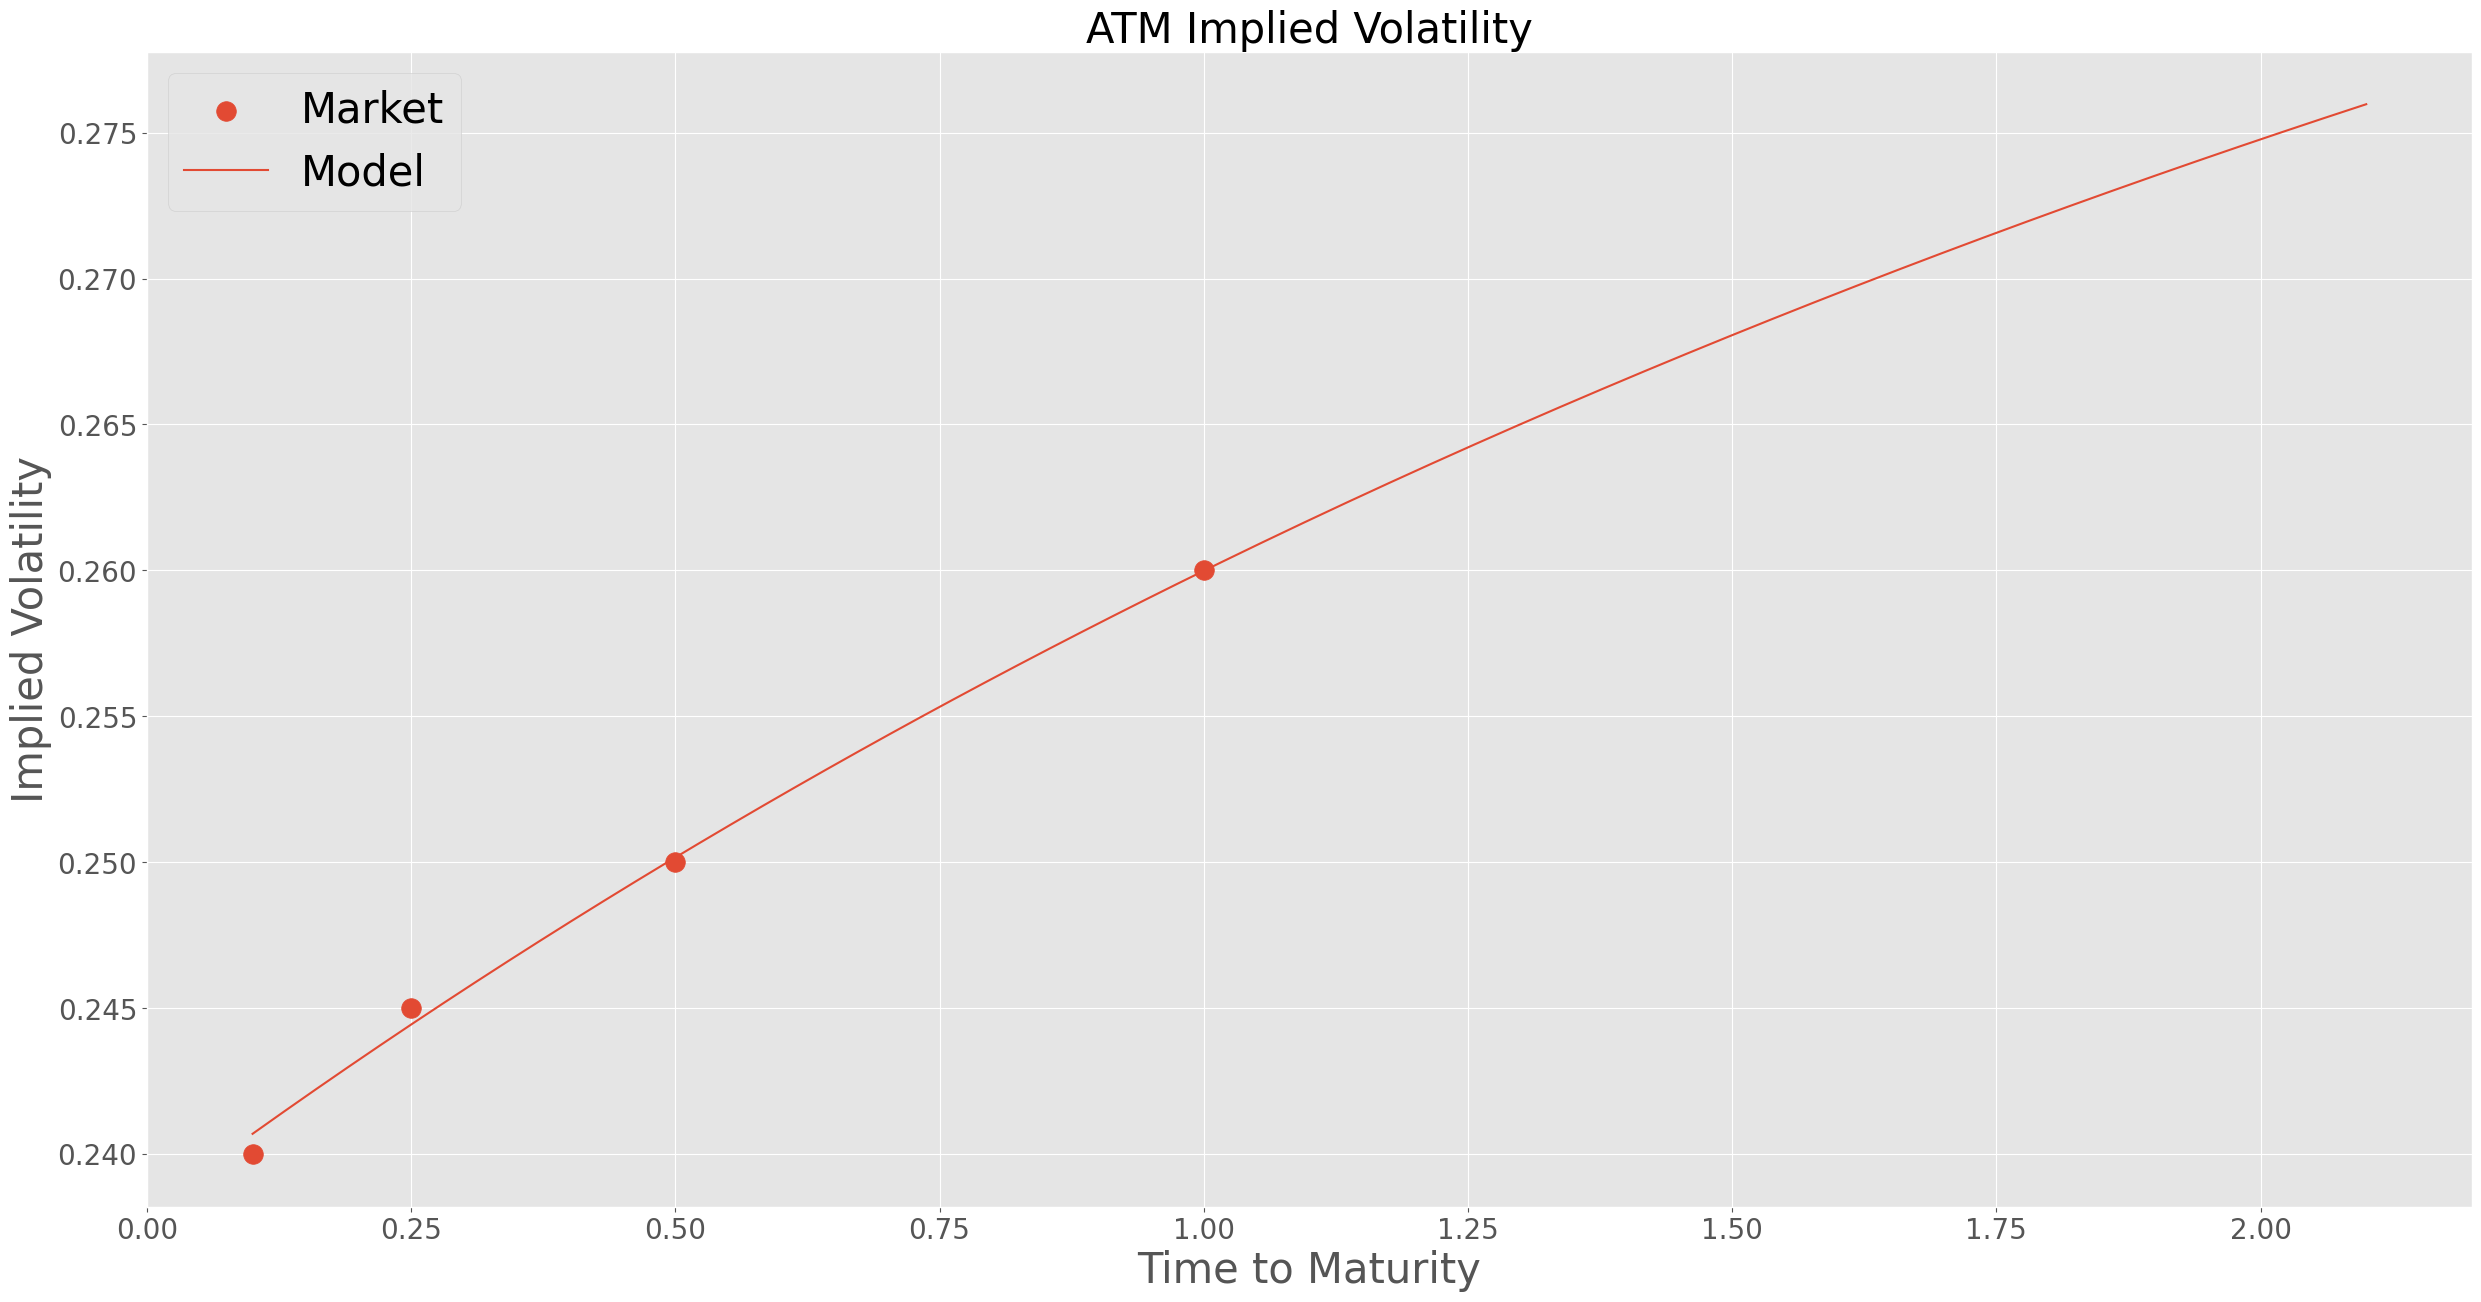

In [23]:
t_ = np.linspace(0.1, 2.1, 200)
nu_0 = 0.2**2
nu_inf = 0.3**2
kappa = 0.5
IV_ATM = [(theta(t, *new_paramsATM)/t)**.5 for t in t_]
fig, axs = plt.subplots(1,figsize = (30, 15))
axs.scatter(T_ATM, Vol_ATM, label="Market", s = 200)
axs.plot(t_, IV_ATM, label = "Model")
axs.set_title('ATM Implied Volatility', fontsize = 30,)
axs.set_xlabel('Time to Maturity', fontsize = 30)
axs.set_ylabel('Implied Volatility', fontsize = 30)
axs.tick_params(axis='x', labelsize = 20)
axs.tick_params(axis='y', labelsize = 20)
axs.legend(fontsize=30)
plt.show()

In [24]:
new_params[0]

np.float64(0.005135376331886448)

In [25]:
def MSE_Price_SSVI(params):
    MSE_Price = 0
    for i in range(len(MarketPrice)):
        MSE_Price = MSE_Price +\
        (CallPrice(S0, (TotalVarSSVI(S0, K[i], T[i], *new_paramsATM, *params)/T[i])**.5,\
            K[i], T[i], r) - MarketPrice[i])**2
    return MSE_Price / len(MarketPrice)
warnings.filterwarnings('ignore')
params = [1.0, -2.0, -0.5]  # initial params (eta, lambda_, rho)
result = minimize(MSE_Price_SSVI, params, method='SLSQP', tol=1e-10)
new_params = result['x']
print("Parameters [eta, lambda_, rho]: " + str(new_params))


Parameters [eta, lambda_, rho]: [ 5.13537633e-03 -4.69086188e-01 -5.65480445e+01]


In [26]:
import numpy as np, math, random
from typing import List, Tuple
# -------------------------------------------------
# 1. Black-Scholes Call price       (no SciPy need)
# -------------------------------------------------
def normal_cdf(x):                       # Φ(x)
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2)))

def bs_call_price(spot, strike, maturity, rate, vol):
    """Black-Scholes European call."""
    if vol <= 0 or maturity <= 0:
        return max(0.0, spot - strike)
    d1 = (math.log(spot / strike) + (rate + 0.5 * vol**2) * maturity) / (vol * math.sqrt(maturity))
    d2 = d1 - vol * math.sqrt(maturity)
    return (spot * normal_cdf(d1) -
            strike * math.exp(-rate * maturity) * normal_cdf(d2))

# -------------------------------------------------
# 2. SSVI helpers
# -------------------------------------------------
def atm_total_variance(t, var0, var_inf, kappa):
    """
    θ(t)  = ((var0 - var_inf)*(1 - e^{-κ t})/(κ t) + var_inf) * t
    """
    return ((var0 - var_inf) * (1 - np.exp(-kappa * t))
            / (kappa * t) + var_inf) * t

def skew_phi(theta_t, eta, lam):
    return eta * theta_t ** lam

def ssvi_total_variance(log_moneyness, theta_t, eta, lam, rho):
    phi_val = skew_phi(theta_t, eta, lam)
    term1   = rho * phi_val * log_moneyness
    term2   = np.sqrt((phi_val * log_moneyness + rho)**2 + 1 - rho**2)
    return 0.5 * theta_t * (1 + term1 + term2)

def ssvi_implied_vol(fwd, strike, maturity,
                     var0, var_inf, kappa,
                     eta, lam, rho):
    """Return σ implied by SSVI."""
    print(strike, fwd)
    k = np.log(strike / fwd)                    # log-moneyness
    theta_t = atm_total_variance(maturity, var0, var_inf, kappa)
    total_var = ssvi_total_variance(k, theta_t, eta, lam, rho)
    return np.sqrt(total_var / maturity)

# -------------------------------------------------
# 3. Example “market” surface (for demo only)
# -------------------------------------------------
rate   = 0.05
fwd    = spot = 100
maturities = np.array([0.1, 0.25, 0.5, 1.0])
strikes    = np.arange(80, 121, 5)

# Ground-truth parameters to generate fake market data
true_var0, true_var_inf, true_kappa = 0.04, 0.09, 0.4
true_eta,  true_lambda,  true_rho   = 0.8,  -0.4, -0.3

market_iv   = []
K_grid      = []
T_grid      = []

for T in maturities:
    for K in strikes:
        iv = ssvi_implied_vol(fwd, K, T,
                              true_var0, true_var_inf, true_kappa,
                              true_eta,  true_lambda,  true_rho)
        market_iv.append(iv)
        K_grid.append(K)
        T_grid.append(T)

market_iv = np.array(market_iv)
K_grid    = np.array(K_grid)
T_grid    = np.array(T_grid)

# -------------------------------------------------
# 4. Simple random-search calibration
#    (pure Python / NumPy, no external optimizer)
# -------------------------------------------------
def random_search(objective:callable, 
                  bounds: List[Tuple[float, float]], 
                  iterations:int=4000): ## Custom Optimization
    best_x, best_val = None, 1e20
    for _ in range(iterations):
        ## Bounds is a list of tuples, each tuple is (lo, hi)
        candidate = np.array([random.uniform(lo, hi) for lo, hi in bounds])
        val = objective(candidate)

        ## Update best_x and best_val if candidate is better
        if val < best_val:
            best_x, best_val = candidate, val
    return best_x

# ---- Stage-A: fit ATM term-structure (var0, var_inf, kappa)
atm_mask = K_grid == fwd
T_atm, iv_atm = T_grid[atm_mask], market_iv[atm_mask]

def atm_loss(params):
    var0, var_inf, kappa = params
    if min(params) <= 0: # keep parameters positive
        return 1e9
    model_iv = np.sqrt(atm_total_variance(T_atm, var0, var_inf, kappa) / T_atm)
    return np.mean((model_iv - iv_atm)**2)

atm_bounds = [(1e-4, 0.2), (1e-4, 0.2), (0.05, 3.0)]
var0_hat, var_inf_hat, kappa_hat = random_search(atm_loss, atm_bounds, 3000)
print(f"ATM   -> var0={var0_hat:.4f}, var_inf={var_inf_hat:.4f}, kappa={kappa_hat:.4f}")

# ---- Stage-B: fit surface (eta, lambda, rho)
def surface_loss(params):
    eta, lam, rho = params
    if eta <= 0 or not (-1 < rho < 1):
        return 1e9
    model_iv = ssvi_implied_vol(fwd, K_grid, T_grid,
                                var0_hat, var_inf_hat, kappa_hat,
                                eta, lam, rho)
    return np.mean((model_iv - market_iv)**2)

surf_bounds = [(0.05, 2.0), (-1.0, 1.0), (-0.999, 0.999)]
eta_hat, lambda_hat, rho_hat = random_search(surface_loss, surf_bounds, 4000)
print(f"Surface -> eta={eta_hat:.4f}, lambda={lambda_hat:.4f}, rho={rho_hat:.4f}")

# -------------------------------------------------
# 5. Quality check (RMSE)
# -------------------------------------------------
fitted_iv = ssvi_implied_vol(fwd, K_grid, T_grid,
                             var0_hat, var_inf_hat, kappa_hat,
                             eta_hat, lambda_hat, rho_hat)
rmse = np.sqrt(np.mean((fitted_iv - market_iv)**2))
print(f"Overall implied-vol RMSE: {rmse:.6f}")


80 100
85 100
90 100
95 100
100 100
105 100
110 100
115 100
120 100
80 100
85 100
90 100
95 100
100 100
105 100
110 100
115 100
120 100
80 100
85 100
90 100
95 100
100 100
105 100
110 100
115 100
120 100
80 100
85 100
90 100
95 100
100 100
105 100
110 100
115 100
120 100
ATM   -> var0=0.0400, var_inf=0.1593, kappa=0.1569
[ 80  85  90  95 100 105 110 115 120  80  85  90  95 100 105 110 115 120
  80  85  90  95 100 105 110 115 120  80  85  90  95 100 105 110 115 120] 100
[ 80  85  90  95 100 105 110 115 120  80  85  90  95 100 105 110 115 120
  80  85  90  95 100 105 110 115 120  80  85  90  95 100 105 110 115 120] 100
[ 80  85  90  95 100 105 110 115 120  80  85  90  95 100 105 110 115 120
  80  85  90  95 100 105 110 115 120  80  85  90  95 100 105 110 115 120] 100
[ 80  85  90  95 100 105 110 115 120  80  85  90  95 100 105 110 115 120
  80  85  90  95 100 105 110 115 120  80  85  90  95 100 105 110 115 120] 100
[ 80  85  90  95 100 105 110 115 120  80  85  90  95 100 105 110 115 120


In [27]:
import numpy as np
from typing import List, Tuple, Callable


# -------------------------------------------------
# 1. Black-Scholes Call price       (no SciPy need)
# -------------------------------------------------
def normal_cdf(x):                       # Φ(x)
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2)))

def bs_call_price(spot, strike, maturity, rate, vol):
    """Black-Scholes European call."""
    if vol <= 0 or maturity <= 0:
        return max(0.0, spot - strike)
    d1 = (math.log(spot / strike) + (rate + 0.5 * vol**2) * maturity) / (vol * math.sqrt(maturity))
    d2 = d1 - vol * math.sqrt(maturity)
    return (spot * normal_cdf(d1) -
            strike * math.exp(-rate * maturity) * normal_cdf(d2))

# -------------------------------------------------
# 2. SSVI helpers
# -------------------------------------------------
def atm_total_variance(t, var0, var_inf, kappa):
    """
    θ(t)  = ((var0 - var_inf)*(1 - e^{-κ t})/(κ t) + var_inf) * t
    """
    return ((var0 - var_inf) * (1 - np.exp(-kappa * t))
            / (kappa * t) + var_inf) * t

def skew_phi(theta_t, eta, lam):
    return eta * theta_t ** lam

def ssvi_total_variance(log_moneyness, theta_t, eta, lam, rho):
    phi_val = skew_phi(theta_t, eta, lam)
    term1   = rho * phi_val * log_moneyness
    term2   = np.sqrt((phi_val * log_moneyness + rho)**2 + 1 - rho**2)
    return 0.5 * theta_t * (1 + term1 + term2)

def ssvi_implied_vol(fwd, strike, maturity,
                     var0, var_inf, kappa,
                     eta, lam, rho):
    """Return σ implied by SSVI."""
    k = np.log(strike / fwd)                    # log-moneyness
    theta_t = atm_total_variance(maturity, var0, var_inf, kappa)
    total_var = ssvi_total_variance(k, theta_t, eta, lam, rho)
    return np.sqrt(total_var / maturity)

def make_candidate(bounds: List[Tuple[float, float]], iterations) -> np.ndarray:
    """
    Generate a random candidate solution within the given bounds.
    bounds: list of (low, high) for each dimension
    """
    rng = np.random.default_rng(42)
    low  = np.array([b[0] for b in bounds])
    high = np.array([b[1] for b in bounds])

    # (iterations, d) matrix of uniform random samples
    candidates = low + (high - low) * rng.random((iterations, len(bounds)))
    return candidates


def random_search_vec(objective_multi: Callable[[np.ndarray], np.ndarray],
                      bounds: List[Tuple[float, float]],
                      iterations: int = 40_000) -> Tuple[np.ndarray, float]:
    """
    Vectorised random search.
    objective_multi: accepts an (N, d) array -> returns (N,) array of losses
    bounds         : list of (low, high) for each dimension
    iterations     : how many random draws
    """

    # vectorised loss evaluation -> (iterations,)
    candidates = make_candidate(bounds, iterations)
    losses = objective_multi(candidates)

    best_idx = np.argmin(losses)
    return candidates[best_idx], losses[best_idx]


def atm_loss_multi(X, t, iv_atm):
    """
    X : (N, 3)  – rows = [var0, var_inf, kappa]
    t, iv_atm   – market ATM maturities and vols (1-D)
    returns     – loss for each row  (shape (N,))
    """
    var0, var_inf, kappa = X[:, 0], X[:, 1], X[:, 2]
    theta_t  = atm_total_variance(t[:, None], var0, var_inf, kappa)  # broadcast
    model_iv = np.sqrt(theta_t / t[:, None])
    mse      = ((model_iv - iv_atm[:, None])**2).mean(axis=0)        # → (N,)
    return mse

def surface_loss_multi(params_mat):
    """
    params_mat : shape (N, 3) – each row [eta, lambda, rho]
    returns    : shape (N,)   – MSE per candidate
    """
    eta, lam, rho = params_mat.T                      # (N,)

    # ---- hard bounds to avoid overflow -----------------------------------
    bad = (eta <= 0) | (lam <= -0.9) | (lam >= 1.0) | (np.abs(rho) >= 0.999)
    # mark bad rows; they get a huge constant loss later
    safe_eta = np.where(bad, 1.0, eta)               # (N,)
    safe_lam = np.where(bad, 0.0, lam)
    safe_rho = np.where(bad, 0.0, rho)

    # ---- broadcast market grid (M,1) with candidates (1,N) --------------
    k  = np.log(K_grid / fwd)[:, None]                # (M,1)
    T  = T_grid[:, None]                              # (M,1)
    theta = atm_total_variance(T, var0_hat, var_inf_hat, kappa_hat)

    # each safe_* is (N,) so reshape to (1,N) for broadcasting
    total_var = ssvi_total_variance(
        k, theta,
        safe_eta[None, :], safe_lam[None, :], safe_rho[None, :]
    )                                                 # → (M,N)

    iv_model = np.sqrt(total_var / T)                 # (M,N)

    # ---- guard against any residual NaN / huge vols ----------------------
    invalid = (~np.isfinite(iv_model)) | (iv_model > 5)   # 500 % vol cutoff
    iv_model = np.where(invalid, 1e4, iv_model)           # penalise

    mse = np.mean((iv_model - market_iv[:, None])**2, axis=0)  # (N,)


    # slam the rows we flagged as ‘bad’
    mse = np.where(bad, 1e9, mse)
    return mse





In [28]:
UPPER_BOUND_MONEYENESS = 1.6
LOWER_BOUND_MONEYENESS = 0.4
DTE_MIN_THRESHOLD = 35
DTE_MAX_THRESHOLD = 730
DUMAS_WIDTH =0.75

aapl_chain['spot'] = S
aapl_chain['vol'] = aapl_chain['bs_vol']
aapl_chain['r'] = rates
aapl_chain['q'] = q
aapl_chain['price'] = aapl_chain['Midpoint']
tgt_right = 'P'

aapl_chain['DTE'] = (aapl_chain['Expiration'] - aapl_chain.index).dt.days
aapl_chain_clipped = aapl_chain[
    (aapl_chain['DTE'] >= DTE_MIN_THRESHOLD) &
    (aapl_chain['DTE'] <= DTE_MAX_THRESHOLD) &
    (aapl_chain['moneyness'] <= UPPER_BOUND_MONEYENESS) &
    (aapl_chain['moneyness'] >= LOWER_BOUND_MONEYENESS) &
    (aapl_chain['Right'] == tgt_right) 
].copy()


In [29]:
T_atm = aapl_chain_clipped[aapl_chain_clipped['moneyness'].between(0.99, 1.01)]['T'].values
iv_atm = aapl_chain_clipped[aapl_chain_clipped['moneyness'].between(0.99, 1.01)]['bs_vol'].values
fwd=aapl_chain_clipped['F'].values
K_grid = aapl_chain_clipped['Strike'].values
T_grid = aapl_chain_clipped['T'].values
rate = aapl_chain_clipped['r'].values[0]  # Assuming constant rate for all options
market_iv= aapl_chain_clipped['bs_vol'].values


# rate   = 0.05
# fwd    = spot = 100
# maturities = np.array([0.1, 0.25, 0.5, 1.0])
# strikes    = np.arange(80, 121, 5)
# market_iv   = []
# K_grid      = []
# T_grid      = []

# for T in maturities:
#     for K in strikes:
#         iv = ssvi_implied_vol(fwd, K, T,
#                               true_var0, true_var_inf, true_kappa,
#                               true_eta,  true_lambda,  true_rho)
#         market_iv.append(iv)
#         K_grid.append(K)
#         T_grid.append(T)

# atm_mask = K_grid == fwd
# T_atm    = np.array([0.1, 0.25, 0.5, 1.0])
# iv_atm   = np.array([0.23, 0.225, 0.24, 0.26])


# market_iv = np.array(market_iv)
# K_grid    = np.array(K_grid)
# T_grid    = np.array(T_grid)


In [30]:


bounds   = [(0.001, 0.2),   # var0
            (0.001, 0.2),   # var_inf
            (0.05,  2.0)]   # kappa

best_params, best_loss = random_search_vec(
        lambda X: atm_loss_multi(X, T_atm, iv_atm),
        bounds,
        iterations=1_000
)
var0_hat, var_inf_hat, kappa_hat = best_params
print("best", best_params, "loss", best_loss)


best [0.07472148 0.09444161 0.41946915] loss 3.662214365945435e-05


In [36]:



# 1️⃣ tighter parameter bounds
surf_bounds = [(0.05, 1.5),      # eta
               (-0.8, 0.8),      # lambda
               (-0.95, 0.95)]    # rho



(eta_hat, lambda_hat, rho_hat), best_loss = random_search_vec(surface_loss_multi,
                                                      surf_bounds, 50_000)

print(f"Surface -> eta={eta_hat:.4f}, lambda={lambda_hat:.4f}, rho={rho_hat:.4f}, loss={best_loss:.6f}")

Surface -> eta=1.4457, lambda=-0.5572, rho=0.1915, loss=0.001129


In [ ]:
# Surface -> eta=1.2655, lambda=-0.5932, rho=0.2058, loss=0.001153

In [37]:
aapl_chain_clipped['T'].unique()

array([0.10130048, 0.12046543, 0.1779603 , 0.3504449 , 0.25462012,
       0.42710472, 1.17453799, 0.59958932, 0.50376454, 1.42368241,
       1.50034223, 0.92265572, 1.9192334 , 0.67624914, 0.82956879])

In [38]:
T_use=aapl_chain_clipped['T'].unique()[9]
print(T_use)
T_use_mask = T_grid ==T_use
C_index = aapl_chain_clipped['Right'] == tgt_right
T_use_index = np.where(T_use_mask & C_index)

K_use = K_grid[T_use_index]
fwd_use = fwd[T_use_index]
log_moneyness = np.log(K_use / fwd_use)
market_iv_use = market_iv[T_use_index]
model_use = ssvi_implied_vol(
    fwd_use, K_use, T_use,
    var0_hat, var_inf_hat, kappa_hat,
    eta_hat, lambda_hat, rho_hat
)
model_use

1.4236824093086926


array([0.27737816, 0.28108719, 0.28782713, 0.2966028 , 0.3065097 ,
       0.31690016, 0.32736845, 0.33768014, 0.34770862, 0.35739144,
       0.36670347, 0.37564078, 0.38421127, 0.43189476, 0.42173591,
       0.4119373 , 0.40246665, 0.39329741, 0.38440803, 0.37578143,
       0.36740474, 0.35926915, 0.35136993, 0.34370667, 0.33628363,
       0.32911031, 0.32220221, 0.3155818 , 0.3092797 , 0.30333596,
       0.29780143, 0.29273878, 0.28822274, 0.28433887, 0.28117968,
       0.2788373 , 0.27739233])

In [39]:
dataframe_vols = pd.DataFrame({
    'K': K_use,
    'log_moneyness': log_moneyness,
    'market_iv': market_iv_use,
    'model_iv': model_use
})
dataframe_vols.sort_values('log_moneyness').plot(
    x='log_moneyness',
    y=['market_iv', 'model_iv'],
    kind='line',
    title=f'SSVI Volatility Surface at T={T_use:.2f} years'

)

In [184]:
fwd[0],\
K_grid[0],\
T_grid[0],\
market_iv[0]

(211.06290118921353, 215.0, 0.10130047912388775, 0.29094924873121825)

In [288]:
def as_column(a):
    """Return a (len,1) column regardless of original rank."""
    return np.asarray(a).reshape(-1, 1)

def as_row(a):
    """Return a (1,len) row regardless of original rank."""
    return np.asarray(a).reshape(1, -1)


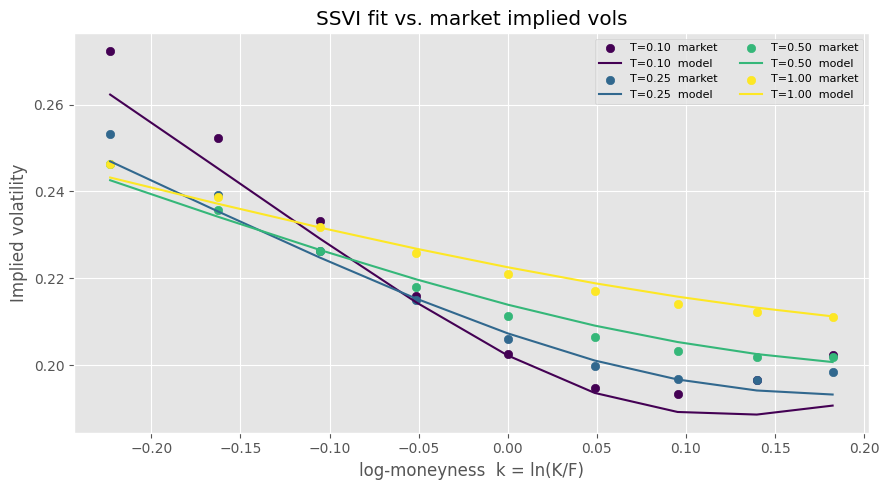

In [186]:
# -------------------------------------------------
# 6. Plot: market IV (dots) vs SSVI fit (lines)
# -------------------------------------------------
import matplotlib.pyplot as plt

unique_T = np.unique(T_grid)
color_map = plt.cm.viridis(np.linspace(0, 1, len(unique_T)))

plt.figure(figsize=(9, 5))
for idx, maturity in enumerate(unique_T):
    sel = T_grid == maturity
    k_vals      = np.log(K_grid[sel] / fwd)          # log-moneyness
    iv_market   = market_iv[sel]
    iv_model    = fitted_iv[sel]

    plt.scatter(k_vals, iv_market, color=color_map[idx],
                label=f"T={maturity:.2f}  market", marker='o')
    plt.plot   (k_vals, iv_model,  color=color_map[idx],
                label=f"T={maturity:.2f}  model")

plt.title("SSVI fit vs. market implied vols")
plt.xlabel("log-moneyness  k = ln(K/F)")
plt.ylabel("Implied volatility")
plt.grid(True)
plt.legend(fontsize=8, ncol=2)
plt.tight_layout()
plt.show()

